In [1]:
import pydrake
import math
import warnings
import random

import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from pydrake.trajectories import PiecewisePolynomial
from pydrake.solvers import mathematicalprogram as mp
from pydrake.systems.framework import InputPortSelection, OutputPortSelection, Context
from pydrake.systems.primitives import LinearSystem,FirstOrderTaylorApproximation
from pydrake.systems.trajectory_optimization import (
    AddDirectCollocationConstraint, DirectCollocation,
    DirectCollocationConstraint, 
    TimeStep,
)
from pydrake.systems.controllers import LinearQuadraticRegulator

from pydrake.examples.pendulum import (PendulumPlant, PendulumState)

# from enum import Enum

In [2]:
#enum example 
from enum import Enum
class Color(Enum):
    RED = 1
    GREEN = 2
    BLUE = 3
print(Color.BLUE)
print(Color.BLUE==3)

Color.BLUE
False


In [2]:
class TreeOptions:
    """
    A helpful class/struct that holds all 
    argument for constructing a lqr tree
    """
    def __init__(self):
        self.nX=2
        self.nU=1
        self.goal_point=np.array([2,0])
        self.dt=.05
        self.input_bounds=np.array([0,1])
        self.state_bounds=np.array([0,1])
#two ways of creating options, 
#one way is to change class
#the other is to change variables
option=TreeOptions()
option.nX=2
option.nU=1
option.goal_point=np.array([2,0])
option.dt=.05
option.input_bounds=np.array([0,1])
option.state_bounds=np.array([0,1])

In [ ]:
def testSample(self,xsample):
    #test whether the current policy covers this sample, i.e. can drive it to goal basin
    #assume stability in goal basin, which is done before calling this function
    #cases: 
    #flag=1: already in goal basin or 
    #        the policy drives it to goal without violating any funnel bound
    #flag=2: not in any funnel
    #flag=3: in at least one funnel/node, and can successfully reach the goal 
    #                                     without violating any funnel bound
    #flag=4: in at least one funnel/node, and can successfully reach the goal 
    #                                     but with violating some funnel bound
    #flag=5: in at least one funnel/node, but can't reach the goal
    
    #question: what if a node is covered by multiple funnels? 
    #Do you test all of them or just the closest one
    #How abt we keep testing until no longer a funnel contains this node
    ####################################################
    
    #check if the sample is already in the goal node by comparing distance with goal node’s eps
    If self.inGoalBasin(xsample):
        return flag=1#syntax's probably off

    closest_node_idx=self.findFunnel(xsample)#find the closest first
                                            #also the start pt for policy
    
    #check if in any funnel
    If closest_node_idx=-1:
        return flag=2#not in any funnel

    #now if the sample is in funnel $node_idx, test if the current policy can drive it to the goal 
    #via simulation , give the closest_node_idx to simTree()

    simulated_traj=self.simTree(xSample, closest_node_idx, dt)#dt is a constant
    
    #If xsample doesn’t end up in goal when going through this trajectory, need to shrink coverage
    #only need to check the last point
    if not self.inGoalBasin(simulated_traj[-1]):
        #Shrink all funnels and check if any eps<0.1, delete corresponding nodes
        undersize_node_idx=self.shrinkFunnel(closest_node_idx)#need to implement
                                                    #returns the index of closest node to the goal 
                                                    #with eps<.1
        if undersize_node_idx!=-1:
            self.deleteNode(undersize_node_idx)
        return flag=4#? or 5
#     Else xsample ends up in goal when going through this trajectory,         

#     check if it stays inside all funnel when going through the trajectory, return flag=1 for this case    
    last_failed_idx=self.checkTraj(simulated_traj,closest_node_idx)
    if last_failed_idx==-1:
        #all pts in bound when moving along the trajectory
        return flag=3

#         #else failed, shrink eps for all funnels before a funnel at which, the sample lands outside, 
#         effectively, you would find the closest funnel to the goal that the sample fails to land in 
#         and shrink the eps for all funnels before it (shrink without including boundary), 
#         check if any eps<0.1, delete corresponding nodes
    undersize_node_idx=self.shrinkFunnelUntil(closest_node_idx,last_failed_idx)
    if undersize_node_idx!=-1:
        self.deleteNode(undersize_node_idx)
        return flag=4#
    #is there an else case
    
def findFunnel(self,xsample):
    #find the closest funnel to the sample pt and return the node index
    #not ambiguous
    
    #calculate the distance from all funnel center to the sample
    #filter only valid pts
    #return the index of the closest valid funnel id
    x=0
def inGoalBasin(self,node_idx):
    #return whether the pt is in goal node
    return False
def deleteNode(self,idx_to_del):
    #assume idx not at goal and has a path to goal
    #delete the node at index and dangling trajectories
    #actually this has to be recursive
    
    #first set the prev node for the next node to -1/null
    #not sure if the neighbors are directed? I believe so
    #every node should only have one next node, which might be null
    next_node_idx=next(XG.neighbors(idx_to_del))#again want to make sure not at goal node
    self.G.nodes[idx_to_del]['prev']=-1
    #now the helper doesn't have to set the prev entry of the remaining pts in graph
    self.deleteNodeHelper(idx_to_del)
    
def deleteNodeHelper(self,idx_to_del):
    #this recursively remove any nodes connected to the idx to del node
    #not sure if the iterator would still be valid if the node is deleted
    #want to check that
    RG_cp=self.G.reverse()#might be creating too many copies, could just make this global tho
    to_del_iter=RG_cp.neighbors(idx_to_del)
    while True:
        try:
            self.deleteNodeHelper(next(to_del_iter))
#             print("s's neighbours are ",next(iter_))
        except (StopIteration,Exception) as e:
#             print(e)
            break
    self.G.remove_node(idx_to_del)
    
        
def checkTraj(self,simulated_traj,closest_node_idx):
    #assume simulated traj include the closest node idx
    #check if the simulated trajectory all fall within the the trajectory from node idx
    #return the last node's idx, at which the trajectory falls outside the eps
    
    cur_node_idx=closest_node_idx
    node_cnt=simulated_traj.shape[0]#? #total number of nodes traveled during the simulation
             #assuming each action at a node gurantee it jumps to the next node
    last_failed_idx=-1
    for i in range(node_cnt):
        node_loc=self.G.nodes[cur_node_idx]['X0']
        node_eps=self.G.nodes[cur_node_idx]['eps']
        sim_loc=simulated_traj[0]
        #todo: check if the simulated location is within node's eps
        if 1:#if failed
            last_failed_idx=cur_node_idx
        #move along the trajectory
        cur_node_idx=next(XG.neighbors(cur_node_idx))
                                        #this will raise an exception 
                                        #if the last node is goal node which has no next node
    return last_failed_idx
def shrinkFunnel(self,closest_node_idx):
    #shrink all funnels along this trajectory, basically until the goal
    #return the index of the closest node to the goal which has eps<.1
    return self.shrinkFunnelUntil(closest_node_idx,GOAL_NODE_IDX)
def shrinkFunnelUntil(self,closest_node_idx,last_failed_idx):
    #start node(inclusive): closest node
    #last node(inclusive): 
    #shrink all funnels along this trajectory until last failed node
    #return the index of the closest node to last failed node which has eps<.1
    
    #while 
    
    x=0
    
def simTree(self, xSample, closest_node_idx, dt):
    return 0
    #Simulate the actual trajectory for xsample moving along the funnels from funnel closest_node_idx
#Only return actual simulated trajectory along with the funnel trajectory and corresponding eps, not comparing their eps inside or not
    
#     For each funnel along the trajectory
#         Use ode45/equivalent to simulate where it ends up after dt with applied u at this funnel and then use this location to apply u calculated from next funnel


In [4]:
for i in range(9):
    print(i)

0
1
2
3
4
5
6
7
8


In [3]:
class LQRTree: 

    def __init__(self, nX, nU, goal_point, dt, plant, input_bounds, 
                 state_bounds):
#     """init all variables related to constructing trees

# maybe merge the input arguments into a single struct for better readability

# There are going to be  a lot of parameters that get set here. 

# dynamics: the plant that the tree will be constructed for 
# input_bounds:   upper and lower bounds on the control inputs 
# state_bounds:   bounds on the state space that we care about 
# num_nearest_neighbors: The number of nearest neighbors to consider, since considered 1 in all cases, not declaring
# time_delta: the time descretization for trajectory 
# Q: state cost matrix 
# R: action cost matrix 
# V_err: amount of error we're willing to tolerate in the value function 
# goal_point: the goal of the LQR tree """

        # save argument for object construction 
        #self.dim=dim#dim[0]--nX,dim[1]--nU
        self.nX=nX
        self.nU=nU
#         self.goal_node=goal_node
        self.plant = plant 
        #context isn't really needed, could always create another one
        self.context =  self.plant.CreateDefaultContext()
#         self.cost_fun = cost_fun
        self.goal_point = goal_point 
        #self.InputLimit = InputLimit
        self.input_bounds=input_bounds
        self.state_bounds=state_bounds
        
        assert(self.state_bounds.shape[0]==self.nX)
        #otherwise, bounds and nX dimension mismatch
        assert(self.input_bounds.shape[0]==self.nU)
        #otherwise, bounds and nU dimension mismatch
        
        self.dt=dt
        
        self.node_cnt=0# stores how many nodes has been added to the graph,
                        # like the idx in the previous code
                        # the next node to add has index = node_cnt
        
        
        # init other variables
        self.G=nx.DiGraph()# node index serves as the key to access node from graph
        self.Q=np.eye(nX)*2#2 is user defined
        self.R=np.eye(nU)*5#5 is user defined
        self.nNodesInit = 10000
        
        
        # to get a list of certain variable
        #list(self.G.nodes(data='node_attr'))
        
#         self.S = zeros([self.nX,self.nX,self.nNodesInit])
#         self.S_1 = zeros([self.nX, self.nNodesInit])
#         self.S_2  = zeros(self.nNodesInit) #Question5: It seems that there is no S_2 in pendulum???
#         self.A = zeros([self.nX,self.nX,self.nNodesInit]) 
#         self.B = zeros([self.nX,self.nU, self.nNodesInit]) 
#         self.K = zeros([self.nX,self.nNodesInit]) 
#         self.epsH = zeros(self.nNodesInit)  
#         self.T = zeros(self.nNodesInit)  
#         self.U0 = zeros([self.nU,self.nNodesInit])  
#         self.X0 = zeros([self.nX,self.nNodesInit]) 
#         self.Qval = zeros(self.nNodesInit)
#         self.Vx = zeros(self.nNodesInit) #Question4: I can't understand how to calculate Vx and Vf and Vx_pt? 
                                            #Cell object? 
        # add goal point to graph
        context_goal=self.plant.CreateDefaultContext()
        context_goal.SetContinuousState(self.goal_point)#what's set discrete state
        self.plant.get_input_port(0).FixValue(context_goal, 0)#if input port not set, it doesn't seem the taylor approx can run, the number of ports vary plants by plants
        affine_sys_goal=FirstOrderTaylorApproximation(self.plant,context_goal)
        K_goal,S_goal = LinearQuadraticRegulator(affine_sys_goal.A(), affine_sys_goal.B(), self.Q, self.R)
        
        # new_node_idx=node_cnt
        # the following code add a node with index/label = node_cnt,
        # along with attributes for this node, like K,S,epsH
        self.G.add_node(self.node_cnt,K=K_goal[0],S=S_goal[0],
                        A= affine_sys_goal.A(),B= affine_sys_goal.B(),
                        epsH= 1,Vx= 0, 
                        #Question6: I don't know how to calculate Vx
                        Qval = 0, X0 = self.goal_point,
                        T = 0,U0= np.array([0]))#want to add a prev info, 
                                                #the next node is implicitby the edge
        print("attributes for goal node, also node[0]: ",self.G.nodes[0])
        # always add 1 to node cnt when adding nodes
        self.node_cnt=self.node_cnt+1
        
    def constructTree(self): 
# """
# 	1) build Time Invariant LQR solution around linearized goal point 
# 	2) Set bound on acceptable value function error 
# 	3) Randomly sample new point
# 	4) Attempt to connect new point to goal point using treeConnect()
# 		4.a) if successful construct funnel around trajectory 
# 		4.b) if not succesful go back to 3 
# 	5) Probabilistically test all of the funnels,
# 	if there is a high probability that a random sample will land 
# 	in a valid funnel, stop go to 2 and set a lower bound. repeat process until desired lower bound is achieved. 
	
# 	"""
        #remeber to add goal node first
        #add_goal_node(G,goal_node)
        #goal already added at class construction

        num_rl_iter=15
        nSuccess=0
        nSuccTerm=459
        Q_thresh=62.5
        Q_max=8000
        
        # for loop, number of full coverage iterations
        for rl_step in range(num_rl_iter):


            # while loop, if there are enough coverage or too many iterations
            while nSuccess < nSuccTerm and Q_max > Q_thresh:
                # generate a random sample in the range and 
                x_sample=getRandSample()

                # test if this sample is covered (Barrett)
                flag=test_sample(x_sample)

                # if covered, continue
                if flag==1:
                    nSuccess=nSuccess+1
                    continue

                # else, add a new trajectory from this random sample to existing tree
                add_traj_from_sample(x_sample)
    
            # end while loop
            Q_max = Q_max*0.8#redundant with for loop?

        #some more work here

        # end for loop
        

    def test_sample(self, x_sample):
        flag=0#to do: test sample and set flag
        return flag
    

        
    def getRandSample(self):
        #either all use array or none uses array 
        x_rand=np.random.rand(self.nX)#,1)
        left_bound=self.state_bounds[:,0]#.reshape(nX,1)
        right_bound=self.state_bounds[:,1]#.reshape(nX,1)
        diff=(right_bound-left_bound)
        x_rand_adjusted=x_rand*diff+left_bound
#         print("rand from np",x_rand)
#         print("diff",diff)
#         print("x_rand_adjusted",x_rand_adjusted)#.flatten())
        
        return x_rand_adjusted
#         x_random = zeros(self.nX)
#         for i in range(self.nX):
#             x_random[i] = random.uniform(self.input_bounds[i,0],self.input_bounds[i,1])
#         return x_random

    def add_traj_from_sample(self, x_sample):

        # first find a (good) goal node in the existing tree to conect to 
        # use value_approx to find all (good) nodes
        context=self.plant.CreateDefaultContext()
        context.SetContinuousState(x_sample)#what's set discrete state
        self.plant.get_input_port(0).FixValue(context, 0)#if input port not set, it doesn't seem the taylor approx can run, the number of ports vary plants by plants
        affine_sys=FirstOrderTaylorApproximation(self.plant,context)
        
        K,S_rand= LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(), self.Q, self.R)
        lqrdist=lambda x1,x2: np.matmul(np.matmul((x2-x1),S_rand),(x2-x1))#might need reshape

#         #for 1/3 case, search and find node with lowest lqrdist
#         #for the rest, randomly pick one from ok neighbours
#         goal_node=1

        arr_epsH=np.array(self.G.nodes(data='epsH'))[:,1]
        arr_X0=np.array(self.G.nodes(data='X0'))[:,1]
        arr_Qval=np.array(tree.G.nodes(data='Qval'))[:,1]
        #want to be able to represent epsH in an array form

#         if np.random.randint(2)==1:
#              goal_indices = np.where(arr_epsH>0.05)[0] #Question1:Idx or Idx+1??
#              distances=[]
#              distances=[np.sqrt(np.sum(np.square(arr_X0[indice]-x_sample))) 
#                         for indice in goal_indices]
#              nearest=np.argsort(distances)
#              goal_node=goal_indices(nearest(0))
#         elif rl_step > 1:#repeated as below
#              ok_neighbors = np.where(arr_Qval<self.valueApprox(x_sample))[0]
#              ok_neighbors = np.where(arr_epsH[ok_neighbors]>0.05)[0]
#              ok_ind = np.random.randint(len(ok_neighbors))
#              goal_node=ok_neighbors(ok_ind)
#         else
#              #ok_neighbors = list(range(0,self.Idx)) #Question2:Idx or Idx+1??# what for
#              ok_neighbors = np.where(arr_epsH>0.05)[0]
#              ok_ind = np.random.randint(len(ok_neighbors))
#              goal_node=ok_neighbors(ok_ind)


#         # use snopt to find a new trajectory
        connect, x_traj_pts, u_traj_pts = treeConnect(self, x_sample, X0(goal_node))
#         # if not connect continue next while loop
        if connect == 0:
            print('Not enough neighbors!')
        # else, then add breakpoints of the trajectory to the graph
        else:
            add_traj(x_traj_pts, u_traj_pts, goal_node) #Question3: how to add Idx to each node?

    def treeConnect(self, start_pt, end_pt): 
        
        context = self.plant.CreateDefaultContext()
        context.SetContinuousState(np.array([3.14, 0]))

        # Setup direct collocation trajectory opitmization 
        dircol = DirectCollocation(
            self.plant, context, num_time_samples=21, minimum_timestep=0.02,
            maximum_timestep=0.5 #Question14
            ,
            input_port_index=InputPortSelection.kUseFirstInputIfItExists,
            assume_non_continuous_states_are_fixed=False)

        dircol.AddDurationBounds(lower_bound=0.5, upper_bound=3.0)
        
        dircol.AddBoundingBoxConstraint(start_pt,
                            start_pt,
                            dircol.initial_state())
        dircol.AddBoundingBoxConstraint(end_pt,
                            end_pt,
                            dircol.final_state())
        # More elegant version is blocked on drake #8315:
        # dircol.AddLinearConstraint(dircol.initial_state()
        #                               == initial_state.get_value())
    
        #make start state equal to start point 
#         dircol.AddLinearConstraint(dircol.initial_state() == start_pt)
    
        #make end state equal to end pt 
#         dircol.AddLinearConstraint(dircol.final_state()   == end_pt)

        #construct collocation constraints
        constraint = DirectCollocationConstraint(plant, context)    
        AddDirectCollocationConstraint(constraint, dircol.timestep(0),
                                          dircol.state(0), dircol.state(1),
                                          dircol.input(0), dircol.input(1),
                                          dircol)

        #Input Constraint 
        u = dircol.input();
        print(u)
        
        dircol.AddConstraintToAllKnotPoints(u[0]>=self.input_bounds[0,0]);
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.input_bounds[0,1]);


        #Trajectory optimization requires an initial guess, even if it's not very good. 
        initial_u = PiecewisePolynomial.ZeroOrderHold([0, .3*21],
                                                   np.zeros((1, 2)))
        initial_x = PiecewisePolynomial()
    
        dircol.SetInitialTrajectory(traj_init_u=initial_u,
                                    traj_init_x=initial_x)


#         dircol.AddRunningCost(self.cost_fun)
        # hardcoding cost function for now
        dircol.AddRunningCost(2*u[0]**2)

        # Solve the trajectory optimization 
        result = mp.Solve(dircol)


        #Retrieve the input and state trajectories 
        input_traj = dircol.ReconstructInputTrajectory(result=result)
        state_traj = dircol.ReconstructStateTrajectory(result=result)

        # yao: there are problem with running codes above related to adding constraints
        # generate a time series with fixed interval excluding the remainder portion at beginning
        # assume u and x trajectory shares the same start and end time
        # returning forward sequence trajectory for easier addition
        # but adding them in reverse
        time_series=np.flip(np.arange(input_traj.end_time(), 
                           input_traj.start_time(), -self.dt))
#         reverse_time_series=np.arange(input_traj.end_time(), 
#                            input_traj.start_time(), -self.dt)
        
        input_traj_pts = np.hstack([input_traj.value(t) for t in                                          
                      time_series])#u traj
        state_traj_pts = np.hstack([state_traj.value(t) for t in                                          
                      time_series])#x traj
        
        #debugging part that makes a plot of state/x traj
        cmds = np.hstack([input_traj.value(t) for t in                                          
                      np.linspace(input_traj.start_time(),                                          
                      input_traj.end_time(), 100)]) 
        x_knots = np.hstack([state_traj.value(t) for t in                                          
                      np.linspace(input_traj.start_time(),                                          
                      input_traj.end_time(), 100)])
        plt.figure() 
        plt.plot(x_knots[0, :], x_knots[1, :]) 
        print("traj takes ",input_traj.end_time())
        print("x")
        print(x_knots[:,0])
        print(x_knots[:,-1])

        print(cmds[0,0])
        print(cmds[0,-1])

        #connect set to 0 to run for now
        #the last element of input_traj_pts is one at end pt 
        #which is already in the graph, so don't add it
        return 0,state_traj_pts,input_traj_pts
#         return [input_traj, state_traj]


#     def funnelConstruction(): 
#     """
#     Use TVLQR to construct a Region of Attraction around the trajectory
#     """
    def valueApprox(self, x_sample):
        arr_Qval=np.array(tree.G.nodes(data='Qval'))[:,1]
        value_estimate = float('inf')
        for idx in range(self.node_cnt):
            dx0 = x_sample - self.G.nodes[idx]['X0']
            uk= self.G.nodes[idx]['U0']
            # J formula questionable, barret's code uses S while Tedrake uses S for approximation and a summation for accurate calculation
            J = np.matmul(np.matmul(dx0,self.Q),dx0)+np.matmul(np.matmul(uk,self.R),uk)
            if (J+arr_Qval[idx]) < value_estimate:
                value_estimate = J+arr_Qval[idx]
        return value_estimate
    
    # there might be a problem with sequence 
    def QvalueTraj(self, i, j, x_traj, u_traj):
        #temporarily commented out for the rest of the codes to run
        return 100
#         time_inverse = np.arange(x_traj.end_time(),x_traj.start_time(),-self.dt)
#         time_pts = time_inverse[::-1]
#         len_traj = len(time_pts)
#         time_diff = j - i
#         discountFactor = 0.99
#         Qval = 0
#         for k in range(time_diff):
#             xk = x_traj.value(time_pts[i+k])
#             uk = u_traj.value(time_pts[i+k])
#             Qval = Qval + math.pow(discountFactor,k)*self.dt*cost(xk, uk) #Question12: need Barrett to double check
            
#         return Qval
    
    def cost(self,xk,uk):
        dx = xk - self.goal_point #Question11: how to use numpy array here to calculate?
        g = np.matmul(np.matmul(dx,self.Q),dx)+np.matmul(np.matmul(uk,self.R),uk)
        
        return g        
    
    def add_traj(self, x_traj_pts, u_traj_pts, goal_node_Idx):#goal node Idx is local
        # what should be the sequence of adding the trajectory
        # adding it reversely saves a loop
        
        # Get discrete time points along trajectory
        # already discretize in treeconnect
#         time_inverse = np.arange(x_traj_pts.end_time(),x_traj_pts.start_time(),-self.dt)
#         time_pts = time_inverse[::-1]
        len_traj = x_traj_pts.shape[1]#number of nodes on the trajectory
        
        Q_base = 0
#         if x_traj_pts.value(time_inverse[0]) != self.goal_point:
        #why global goal?
    #might be [:,-1] to access Question13
#         if x_traj_pts[-1] != self.goal_point:#last pt should be the local goal node
#             Q_base = Qval(goal_node_Idx) #Question7: I can't relate Idx to the end point to get Qval 
        #codes above temporarily commented out to remove dependece on the goal node idx and allow testing
        
        node_cnt_begin=self.node_cnt
        prev_node_idx=goal_node_Idx
        discountFactor = 0.99
#         Idx_path = []
        
        # adding trajectory in reverse
        # len traj must not be 0 or 1?
        for i in range(len_traj-2,-1,-1): #Question8: Is range(len_traj)-1-0+1or not? Should we add Idx from end or begin?
            traj_pt_i=x_traj_pts[:,i]
            u_pt_i=u_traj_pts[:,i]
            #linearize around this pt
            context=self.plant.CreateDefaultContext()
            context.SetContinuousState(traj_pt_i)#what's set discrete state
            self.plant.get_input_port(0).FixValue(context, 0)#if input port not set, it doesn't seem the taylor approx can run, the number of ports vary plants by plants
            affine_sys=FirstOrderTaylorApproximation(self.plant,context)
            K_local,S_local = LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(), self.Q, self.R)
            
            # need to be careful with i
            qval=math.pow(discountFactor,i)*Q_base + self.QvalueTraj(i, len_traj, 
                                                                x_traj_pts, 
                                                                u_traj_pts)
            prev_qval=self.G.nodes[prev_node_idx]['Qval']
            #might be a divide/sqrt of zero here
            vx= qval - prev_qval/ np.sqrt(np.sum(np.square(traj_pt_i-self.G.nodes[prev_node_idx]['X0'])))#might need a sum?
            # the following code add a node with index/label = node_cnt,
            # along with attributes for this node, like K,S,epsH
            self.G.add_node(self.node_cnt,K=K_local[0],S=S_local[0],
                        A= affine_sys.A(),B= affine_sys.B(),
                        epsH= 1000,
                        #Question9: What number should we initiate epsH? *0.8 may not appropriate
                        Vx= vx,#need to figure out sequence of add nodes 
                        #Question6: I don't know how to calculate Vx
                        Qval = qval, X0 = traj_pt_i,
                        T = 0,#questionable, what's the use of this variable
                        U0= u_pt_i)
            
            edge_weight=qval-prev_qval
            self.G.add_edge(self.node_cnt,prev_node_idx,weight=edge_weight)
#             print("attributes for goal node, also node[0]: ",self.G.nodes[0])
            prev_node_idx=self.node_cnt
            # always add 1 to node cnt when adding nodes
            self.node_cnt=self.node_cnt+1
            
#             self.K[:,self.Idx+added_count] = K_local[0]
#             self.S[:,:,self.Idx+added_count] = S_local[0]
#             self.S_1[:,self.Idx+added_count] = 0
#             self.A[:,:,self.Idx+added_count] = affine_sys.A()
#             self.B[:,:,self.Idx+added_count] = affine_sys.B()
#             self.epsH[self.Idx+added_count] = 1000 
#             self.Qval[self.Idx+added_count] = math.pow(discountFactor,len_traj-i)*Q_base + QvalueTraj(i, len_traj, x_traj_pts, u_traj_edges)
#             self.Vx[self.Idx+added_count] = (self.Qval[self.Idx+added_count] - self.Qval[self.Idx+added_count-1])/np.sqrt(np.square(x_traj_pts.value(time_pts[i])-x_traj_pts.value(time_pts[i-1])))
#             #Question6: I don't know how to calculate Vx, and the difference between the first and last point for Vx and weight has problem
#             self.X0[:,self.Idx+added_count] = traj_i
#             self.T[self.Idx+added_count] = time_pts[i]
#             self.U0[:,self.Idx+added_count] = u_traj_edges.value(time_pts[i])
#             added_count = added_count+1
      
    def print_tree(self):
        """
        print all the essential/helpful information about the constructed tree
        """
        print("This tree now has %d nodes"%(self.node_cnt))
        XG=self.G
        nodes=self.G.nodes
        cnt=0
        # iterate over nodes
        for n in list(self.G.nodes):
            cnt=cnt+1
            print("node name: ",n,", location: ",XG.nodes[n]['X0'],", action: ",XG.nodes[n]['U0'])
            #only printing 20 nodes
            if(cnt>20):
                print("...")
                break
    
    def plot_tree(self):
        """
        PLot the tree for visualization of the sequence nodes are added to the tree
        It might also be possible to plot certain attributes
        
        mayavi could be used to visualize in 3D
        """
        XG=self.G
#         nx.draw(XG, pos=nx.circular_layout(XG), with_labels=True, node_color='r', edge_color='b')
        nx.draw(XG, pos=dict(XG.nodes(data='X0')), 
                with_labels=True, node_color='r', edge_color='b')
#             Idx_path #Questwww.ion10: how to calculate Idx_path and edges?
#     def saveLQRTree(): 
#     """
#     Save the LQR Tree using pickle so that it can be used later. 
#     """

#     def loadLQRTree(): 
#     """ 
#     load a pickled tree so that tree construction can be bypassed
#     """
#     def QvaluePt(self, x, u):
        

#     def runLQRTreeController(): 
#     """ 
#     Must have a loaded tree from either the construct tree or LoadLQRTree functions. 
#     """

In [4]:
# object init test
plant = PendulumPlant()
goal_point=np.array([2,0])
dt=.05
state_bounds=np.array([[-1,0],
                      [2,3]],dtype=np.float64)
input_bounds=np.array([[-3,3]],dtype=np.float64)
tree=LQRTree(2,1,goal_point,dt,plant,input_bounds,state_bounds)


attributes for goal node, also node[0]:  {'K': array([4.17813692, 1.48084422]), 'S': array([17.91142018,  5.22267115]), 'A': array([[ 0.        ,  1.        ],
       [ 8.16480093, -0.4       ]]), 'B': array([[0.],
       [4.]]), 'epsH': 1, 'Vx': 0, 'Qval': 0, 'X0': array([2, 0]), 'T': 0, 'U0': array([0])}


This tree now has 1 nodes
node name:  0 , location:  [2 0] , action:  [0]


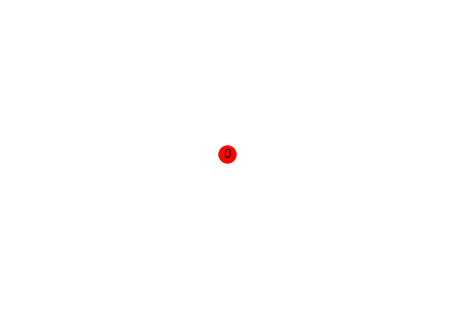

In [5]:
# print_tree & plot tree test
tree.print_tree()
tree.plot_tree()

In [6]:
# add_traj_from_sample test untested, need tree_connect to return connect function
# QvalueTraj not tested, not implemented correctly
# cost not tested

[Variable('u(0)', Continuous)]
traj takes  3.0
x
[0. 0.]
[2.0000000e+00 4.4408921e-16]
-0.8668279022953375
0.5333167048340649


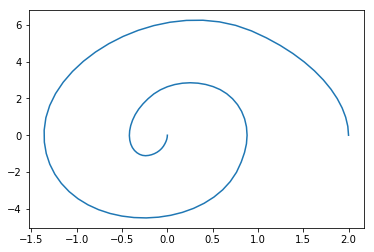

In [7]:
#tree connect test
#debug image of the generated trajectory drawn in code
start_pt=np.array([[0],[0]],dtype=np.float64)
# end_pt=np.array([[3],[0]],dtype=np.float64)
connect,x_traj_pts,u_traj_pts=tree.treeConnect(start_pt, goal_point)

This tree now has 60 nodes
node name:  0 , location:  [2 0] , action:  [0]
node name:  1 , location:  [1.97840902 0.80537818] , action:  [0.66951247]
node name:  2 , location:  [1.9144804  1.63750864] , action:  [0.80570823]
node name:  3 , location:  [1.80948063 2.47645757] , action:  [0.941904]
node name:  4 , location:  [1.6646762  3.30229114] , action:  [1.07809976]
node name:  5 , location:  [1.4813336  4.09507555] , action:  [1.21429552]
node name:  6 , location:  [1.26071932 4.83487696] , action:  [1.35049129]
node name:  7 , location:  [1.00409985 5.50176157] , action:  [1.48668705]
node name:  8 , location:  [0.71819883 6.01407045] , action:  [1.46756529]
node name:  9 , location:  [0.4204104  6.23855638] , action:  [1.40322225]
node name:  10 , location:  [0.11974206 6.1982873 ] , action:  [1.33887921]
node name:  11 , location:  [-0.17519906  5.92197591] , action:  [1.27453618]
node name:  12 , location:  [-0.45580585  5.43833488] , action:  [1.21019314]
node name:  13 , loc

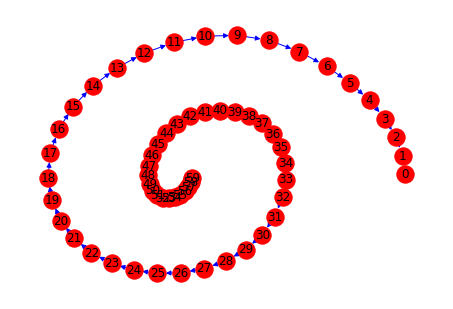

In [8]:
# add_traj test
tree.add_traj(x_traj_pts, u_traj_pts, 0)
tree.print_tree()
tree.plot_tree()

In [9]:
# getRandSample test
x_sample=tree.getRandSample()
print("randomly generated sample: ",x_sample)

randomly generated sample:  [-0.80537796  2.10371549]


In [10]:
# valueApprox test
print("approximate value for the random sample above: ",
      tree.valueApprox(x_sample))

approximate value for the random sample above:  24.591528654774457


## ignore stuffs below

In [190]:
# ways to access data in different structures
# maybe repeated conversion has an overhead but shouldn't be too much each time
# list(tree.G.nodes(data='epsH')) # as a list, first col node name/index,
                                    #second row data
# np.array((tree.G.nodes(data='epsH'))) # as an np array, same as above
np.array((tree.G.nodes(data='epsH')))[:,1]

TypeError: object of type 'int' has no len()

In [198]:
arr_epsH=np.array(tree.G.nodes(data='epsH'))[:,1]
arr_X0=np.array(tree.G.nodes(data='X0'))[:,1]
arr_Qval=np.array(tree.G.nodes(data='Qval'))[:,1]
#         if np.random.randint(2)==1:
#              goal_indices = np.where(arr_epsH>0.05)[0] #Question1:Idx or Idx+1??
#              distances=[]
#              distances=[np.sqrt(np.sum(np.square(arr_X0[indice]-x_sample))) 
#                         for indice in goal_indices]
#              nearest=np.argsort(distances)
#              goal_node=goal_indices(nearest(0))
#         elif rl_step > 1:
#              ok_neighbors = np.where(arr_Qval<self.valueApprox(x_sample))[0]
#              ok_neighbors = np.where(arr_epsH[ok_neighbors]>0.05)[0]#repeated as below
#              ok_ind = np.random.randint(len(ok_neighbors))
#              goal_node=ok_neighbors(ok_ind)
#         else
#              #ok_neighbors = list(range(0,self.Idx)) #Question2:Idx or Idx+1??# what for
#              ok_neighbors = np.where(arr_epsH>0.05)[0]
#              ok_ind = np.random.randint(len(ok_neighbors))
#              goal_node=ok_neighbors(ok_ind)


In [253]:
ok_neighbors = np.where(arr_Qval<tree.valueApprox(x_sample))[0]
ok_neighbors

array([0])

In [256]:
arr_epsH[ok_neighbors]

array([1])

In [255]:
[arr_epsH(idx) for idx in ok_neighbors]

TypeError: 'numpy.ndarray' object is not callable

In [241]:
np.where(arr_Qval<tree.valueApprox(x_sample))# this might give no points

(array([0]),)

In [240]:
tree.valueApprox(x_sample)

24.544207217309335

array([-0.54648502,  2.40572601])

In [166]:
goal_indices=np.where(arr_epsH>0.05)[0]

In [182]:
distances=[np.sqrt(np.sum(np.square(arr_X0[indice]-x_sample))) 
                        for indice in goal_indices]
nearest=np.argsort(distances)
nearest

array([43, 42, 44, 41, 16, 15, 40, 39, 45, 38, 37, 36, 46, 14, 17, 35, 47,
        3, 13, 34,  4, 48,  2,  5, 59, 18, 58, 49,  1, 33,  6, 12, 57, 50,
       56, 51, 55,  7, 54, 52,  0, 53, 11, 19, 32,  8, 10,  9, 31, 20, 30,
       21, 29, 22, 28, 23, 27, 24, 26, 25])

attributes for goal node, also node[0]:  {'K': array([4.17813692, 1.48084422]), 'S': array([17.91142018,  5.22267115]), 'A': array([[ 0.        ,  1.        ],
       [ 8.16480093, -0.4       ]]), 'B': array([[0.],
       [4.]]), 'epsH': 1, 'Vx': 0, 'Qval': 0, 'X0': array([2, 0]), 'T': 0, 'U0': array([0])}
[Variable('u(0)', Continuous)]
traj takes  3.0
x
[0. 0.]
[2.0000000e+00 4.4408921e-16]
-0.8668279022953375
0.5333167048340649


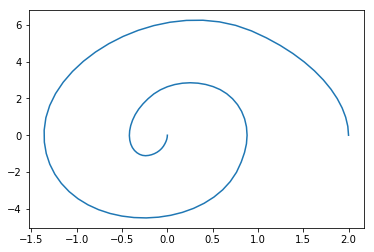

In [7]:
plant = PendulumPlant()
goal_point=np.array([2,0])
dt=.05
state_bounds=np.array([[-1,0],
                      [2,3]],dtype=np.float64)
input_bounds=np.array([[-3,3]],dtype=np.float64)
tree=LQRTree(2,1,goal_point,dt,plant,input_bounds,state_bounds)
start_pt=np.array([[0],[0]],dtype=np.float64)
# end_pt=np.array([[3],[0]],dtype=np.float64)
connect,x_traj_pts,u_traj_pts=tree.treeConnect(start_pt, goal_point)

In [152]:
tree.input_bounds[0,0]

-3.0

In [103]:
x_traj_pts.shapean be stored in three different places:

(2, 60)

In [85]:
# for i in range(x_traj_pts.shape[1]-1,-1,-1):
#     print(i)

This tree now has 1 nodes
node name:  0 , location:  [2 0] , action:  [0]


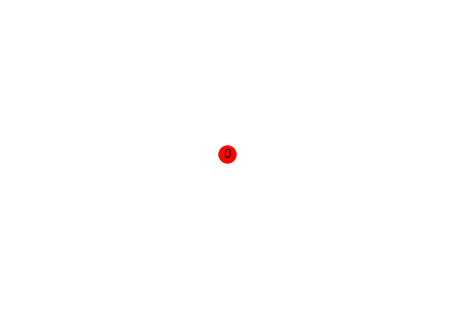

In [8]:
tree.print_tree()
tree.plot_tree()

This tree now has 60 nodes
node name:  0 , location:  [2 0] , action:  [0]
node name:  1 , location:  [1.97840902 0.80537818] , action:  [0.66951247]
node name:  2 , location:  [1.9144804  1.63750864] , action:  [0.80570823]
node name:  3 , location:  [1.80948063 2.47645757] , action:  [0.941904]
node name:  4 , location:  [1.6646762  3.30229114] , action:  [1.07809976]
node name:  5 , location:  [1.4813336  4.09507555] , action:  [1.21429552]
node name:  6 , location:  [1.26071932 4.83487696] , action:  [1.35049129]
node name:  7 , location:  [1.00409985 5.50176157] , action:  [1.48668705]
node name:  8 , location:  [0.71819883 6.01407045] , action:  [1.46756529]
node name:  9 , location:  [0.4204104  6.23855638] , action:  [1.40322225]
node name:  10 , location:  [0.11974206 6.1982873 ] , action:  [1.33887921]
node name:  11 , location:  [-0.17519906  5.92197591] , action:  [1.27453618]
node name:  12 , location:  [-0.45580585  5.43833488] , action:  [1.21019314]
node name:  13 , loc

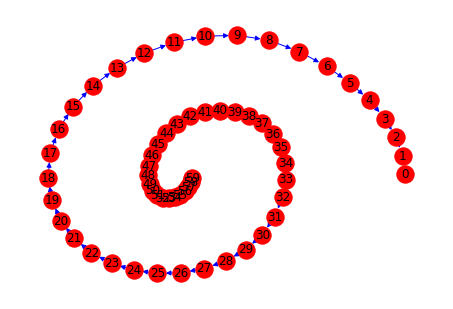

In [9]:
tree.add_traj(x_traj_pts, u_traj_pts, 0)
tree.print_tree()
tree.plot_tree()

In [65]:
XG.nodes[1]['X0']

array([3., 0.])

In [68]:
XG.nodes[0]['X0']

array([2, 0])

In [66]:
XG.nodes(data='X0')

NodeDataView({0: array([2, 0]), 1: array([3., 0.]), 2: array([2.98905746, 0.51277485]), 3: array([2.95526451, 1.00767844]), 4: array([2.89717316, 1.49641852]), 5: array([2.81333543, 1.99070285]), 6: array([2.70230332, 2.5022392 ]), 7: array([2.56262884, 3.04273531]), 8: array([2.39286402, 3.62389897]), 9: array([2.19156085, 4.25743791]), 10: array([1.95727135, 4.95505991]), 11: array([1.68854754, 5.72847273]), 12: array([1.38323418, 6.43733715]), 13: array([1.04748992, 6.93239969]), 14: array([0.69233758, 7.21199673]), 15: array([0.32879998, 7.27446464]), 16: array([-0.03210006,  7.11813979]), 17: array([-0.37933972,  6.74135855]), 18: array([-0.70189619,  6.14245729]), 19: array([-0.98874664,  5.31977239]), 20: array([-1.22886825,  4.27164021]), 21: array([-1.41123821,  2.99639712]), 22: array([-1.52766748,  1.69053627]), 23: array([-1.58321356,  0.56026236]), 24: array([-1.58567528, -0.43249152]), 25: array([-1.53902693, -1.3800242 ]), 26: array([-1.44713877, -2.26663097]), 27: array

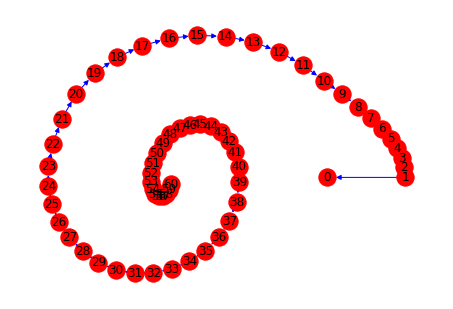

In [67]:
XG=tree.G
nx.draw(XG, pos=dict(XG.nodes(data='X0')), 
                with_labels=True, node_color='r', edge_color='b')

In [62]:
nx.to_dict_of_dicts(tree.G)

{0: {},
 1: {0: {'weight': 100.0}},
 2: {1: {'weight': 0.0}},
 3: {2: {'weight': 0.0}},
 4: {3: {'weight': 0.0}},
 5: {4: {'weight': 0.0}},
 6: {5: {'weight': 0.0}},
 7: {6: {'weight': 0.0}},
 8: {7: {'weight': 0.0}},
 9: {8: {'weight': 0.0}},
 10: {9: {'weight': 0.0}},
 11: {10: {'weight': 0.0}},
 12: {11: {'weight': 0.0}},
 13: {12: {'weight': 0.0}},
 14: {13: {'weight': 0.0}},
 15: {14: {'weight': 0.0}},
 16: {15: {'weight': 0.0}},
 17: {16: {'weight': 0.0}},
 18: {17: {'weight': 0.0}},
 19: {18: {'weight': 0.0}},
 20: {19: {'weight': 0.0}},
 21: {20: {'weight': 0.0}},
 22: {21: {'weight': 0.0}},
 23: {22: {'weight': 0.0}},
 24: {23: {'weight': 0.0}},
 25: {24: {'weight': 0.0}},
 26: {25: {'weight': 0.0}},
 27: {26: {'weight': 0.0}},
 28: {27: {'weight': 0.0}},
 29: {28: {'weight': 0.0}},
 30: {29: {'weight': 0.0}},
 31: {30: {'weight': 0.0}},
 32: {31: {'weight': 0.0}},
 33: {32: {'weight': 0.0}},
 34: {33: {'weight': 0.0}},
 35: {34: {'weight': 0.0}},
 36: {35: {'weight': 0.0}},
 

In [23]:
tree.G[0]['X0']

KeyError: 'X0'

In [4]:
tree.plant
x_sample=np.array([[2,1]])
x_sample

NameError: name 'tree' is not defined

In [87]:
for i in range(10,0,-1):
    print(i)

10
9
8
7
6
5
4
3
2
1


In [10]:
# Start = 5, Stop = 30, Step Size = 2
# arr = np.arange(5, 30, 2)
# np.arange(.5, 3.1, .2)
#generate a time series with fixed interval excluding the remainder portion at beginning
np.flip(-np.arange(-3.1, -.5, .2))

array([0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1])

In [11]:
np.flip(np.arange(3.1, .5, -.2))

array([0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1])

In [13]:
x_sample[-1]

NameError: name 'x_sample' is not defined

In [42]:
np.array([[1,1]],dtype=np.double).shape

(1, 2)

In [45]:
np.array([[1],[1]],dtype=np.float64).shape

(2, 1)

attributes for goal node, also node[0]:  {'K': array([4.17813692, 1.48084422]), 'S': array([17.91142018,  5.22267115]), 'A': array([[ 0.        ,  1.        ],
       [ 8.16480093, -0.4       ]]), 'B': array([[0.],
       [4.]]), 'epsH': 1, 'Vx': 0, 'Qval': 0, 'X0': array([2, 0]), 'T': 0, 'U0': 0}
[Variable('u(0)', Continuous)]
x
[0. 0.]
[3. 0.]
-1.7322917118136798
-1.935871735248757


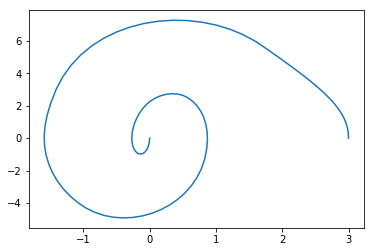

In [12]:
tree=LQRTree(2,1,goal_point,dt,plant,bounds,bounds)
start_pt=np.array([[0],[0]],dtype=np.float64)
end_pt=np.array([[3],[0]],dtype=np.float64)
connect,x_traj_pts,u_traj_pts=tree.treeConnect(start_pt, end_pt)

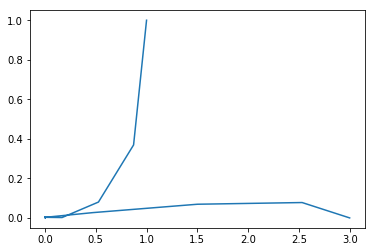

In [70]:
plt.figure() 
plt.plot(x_traj_pts[0, :], x_traj_pts[1, :]) 

In [62]:
# plt.plot(u_traj_pts)

In [85]:
x_traj_pts.shape[1]

81

In [56]:
u_traj_pts.shape

(1, 81)

In [65]:
u_traj_pts

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [12]:
context=tree.plant.CreateDefaultContext()
context.SetContinuousState(x_sample)#what's set discrete state
tree.plant.get_input_port(0).FixValue(context, 0)#if input port not set, it doesn't seem the taylor approx can run, the number of ports vary plants by plants
        
affine_sys=FirstOrderTaylorApproximation(tree.plant,context)
        
(K,S_rand)= LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(), tree.Q, tree.R)
# lqrdist=lambda x1,x2: np.matmul(np.matmul((x2-x1),S_rand),(x2-x1).T)#might need reshape

In [13]:
S_rand

array([[17.91142018,  5.22267115],
       [ 5.22267115,  1.85105528]])

In [68]:
x1=np.array([1,2])
x2=np.array([1,2.2])
np.matmul(np.matmul((x2-x1),S_rand),(x2-x1).T)

0.0839816940468827

In [65]:
np.matmul(x1,S_rand)

array([32.03156301,  9.59182658])

In [69]:
np.matmul(S_rand,x1)

array([32.03156301,  9.59182658])

In [85]:
a = np.random.rand(20)
b=np.where(a>0.5)[0]
print(a)
print(b.shape)

[0.98655334 0.27764843 0.49612294 0.65058687 0.45095504 0.89131656
 0.47171691 0.51001779 0.11851979 0.02866186 0.2947414  0.02042693
 0.04805462 0.71181572 0.45322501 0.81868089 0.02094981 0.48239075
 0.06280244 0.40120439]
(6,)


In [106]:
print(np.zeros(2))

[0. 0.]


(array([ 6,  8, 10, 12, 16, 19]),)

In [100]:
print(list(range(0,10)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [116]:
import numpy

a = numpy.arange(0.52,0.1,-0.05)
print(a)
b = a[::-1]
print(b)

[0.52 0.47 0.42 0.37 0.32 0.27 0.22 0.17 0.12]
[0.12 0.17 0.22 0.27 0.32 0.37 0.42 0.47 0.52]


In [2]:
import random
a=random.uniform(3,8)
print(a)

7.047396137390664


In [120]:
math.pow(4,2)

16.0